In [1]:
#!pip install yfinance
#!pip install hmmlearn
#pip install arch
#pip install scipy
#pip install --upgrade --user hmmlearn
#pip install --user git+https://github.com/hmmlearn/hmmlearn

In [2]:
import yfinance as yf
import numpy as np
from numpy import random
import pandas as pd
import datetime as dt
from datetime import datetime
from scipy.stats import chi2, t, norm
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score 
from sklearn.mixture import GaussianMixture
from hmmlearn import hmm
from hmmlearn.hmm import GaussianHMM 
import statsmodels.api as sm
from itertools import product
from arch import arch_model
import matplotlib.pyplot as plt

# Data collection

In [4]:
ticker = "^GSPC"  #S&P 500 index symbol
daily = yf.download(ticker, start="1950-01-01", end="2024-11-30", interval="1d")
#daily.loc[(daily['Open'] == 0) & (daily.index >= '1961-12-29') & (daily.index <= '1982-04-20'), 'Open'] = np.nan
#Before 29th Dec 1961, same values in the row
#Between 29th Dec 1961 and 20th April 1982, "Open" set to 0

daily = daily[daily.columns[0:4]]

[*********************100%%**********************]  1 of 1 completed


In [5]:
# Resample the data to monthly frequency
monthly = daily.resample('MS').agg({'Open': 'first','High': 'max','Low': 'min','Close': 'last'})
monthly = monthly.dropna()
monthly_with_dates = monthly

# Reset the index to have 'Date' as a column
monthly = monthly.reset_index()

# Calculate log returns
log_returns = np.log(monthly_with_dates['Close'] / monthly_with_dates['Close'].shift(1)).dropna()


<Axes: >

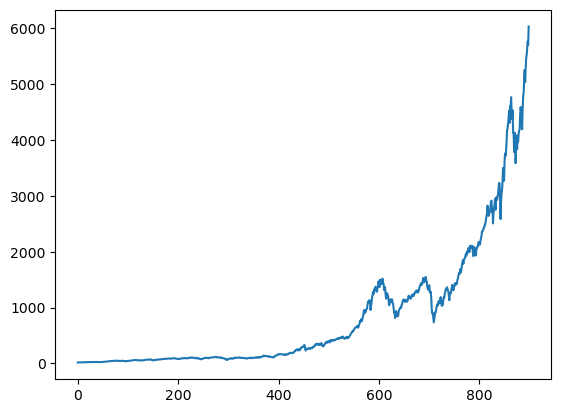

In [6]:
monthly['Close'].plot()

# ADF Test

We run a Dickey-Fuller test to test for the stationnarity of our time series. Our result shows that the time series is not stationary which means that the stastiscal properties are not constant over time. This non stationarity leads to several issues such as

In [9]:
True_price = monthly_with_dates['Close']
print(True_price.shape)

(899,)


In [10]:
True_price

Date
1950-01-01      17.049999
1950-02-01      17.219999
1950-03-01      17.290001
1950-04-01      17.959999
1950-05-01      18.780001
                 ...     
2024-07-01    5522.299805
2024-08-01    5648.399902
2024-09-01    5762.479980
2024-10-01    5705.450195
2024-11-01    6032.379883
Freq: MS, Name: Close, Length: 899, dtype: float64

In [11]:
sm.tsa.stattools.adfuller(True_price, regression='n', autolag='BIC', store=False, regresults=True)

(5.530603168749355,
 1.0,
 {'1%': -2.5682738268565344,
  '5%': -1.941308107020567,
  '10%': -1.616522983799078},
 <statsmodels.stats.diagnostic.ResultsStore at 0x16820b790>)

In [12]:
sm.tsa.stattools.adfuller(True_price, regression='c', autolag='BIC', store=False, regresults=True)

(4.977697371218509,
 1.0,
 {'1%': -3.4377689935918783,
  '5%': -2.864815046188292,
  '10%': -2.5685138660653957},
 <statsmodels.stats.diagnostic.ResultsStore at 0x16823c190>)

In [13]:
sm.tsa.stattools.adfuller(True_price, regression='ct', autolag='BIC', store=False, regresults=True)
#we cannot reject H0 which means that the TS is non-stationary

(3.5312595451308604,
 1.0,
 {'1%': -3.969047635796577,
  '5%': -3.415468144550754,
  '10%': -3.1299799419503365},
 <statsmodels.stats.diagnostic.ResultsStore at 0x1683742d0>)

To overcome this issues, we transform the time series into a stationary one by differenciating each price by one lag. Now, when we run the ADF test, the null hypothesis is rejected i.e the time series is stationary.

In [15]:
True_price_diff = True_price.diff().dropna()  # We differenciate the TS to make it stationnary


In [16]:
sm.tsa.stattools.adfuller(True_price_diff, regression='n', autolag='BIC', store=False, regresults=True)
# Now it is stationary

(-5.718159037552278,
 3.703569075127272e-08,
 {'1%': -2.5682567137987626,
  '5%': -1.941306001663903,
  '10%': -1.6165249633898795},
 <statsmodels.stats.diagnostic.ResultsStore at 0x168374850>)

In [17]:
sm.tsa.stattools.adfuller(True_price_diff, regression='c', autolag='BIC', store=False, regresults=True)

(-6.048662561267591,
 1.2933615273721426e-07,
 {'1%': -3.43771883253448,
  '5%': -2.8647929301713977,
  '10%': -2.568502085595253},
 <statsmodels.stats.diagnostic.ResultsStore at 0x168377290>)

In [18]:
sm.tsa.stattools.adfuller(True_price_diff, regression='ct', autolag='BIC', store=False, regresults=True)

(-6.667193399524683,
 7.882817558710029e-08,
 {'1%': -3.9689781021789607,
  '5%': -3.415434505721528,
  '10%': -3.1299601554678294},
 <statsmodels.stats.diagnostic.ResultsStore at 0x16833b890>)

# Ljung box test

Now that we have a stationary time series, we want to check for autocorrelation in the white noise. In other words, we want to see if the white have serial dependance. By looking at the result of the Ljung-Box test we see that indeed there is autocorelation in the white noise.

In [21]:
n_autocor = 5
sm.stats.diagnostic.acorr_ljungbox(True_price_diff, lags=[n_autocor])
#so there is autocorrelations in the residuals

,lb_stat,lb_pvalue
5,25.889188,0.000094


# ARMA model

Now, we try to apply a ARMA process on the time series to account for the serial dependance in our series. 

In [24]:
ar_order = [0, 1, 2, 3, 4, 5]
d_order = [0]
ma_order = [0, 1, 2, 3, 4]
arma_res = [list(orders) for orders in product(ar_order, d_order, ma_order)]

for order in arma_res:
    print('fitting: ar:{} -d:{} - ma:{}'.format(*order)) 
    try:
        arma_model = sm.tsa.arima.ARIMA(True_price_diff, order=order).fit()
        order.extend([arma_model.aic / 1e3, arma_model.bic / 1e3])
    except Exception as exception:
        print(exception.__str__())
        order.extend([np.NaN, np.NaN])
    
res = pd.DataFrame(arma_res, columns = ['ar_order', 'd_order', 'ma_order', 'aic', 'bic'])
print('criterion\n', res)

fitting: ar:0 -d:0 - ma:0
fitting: ar:0 -d:0 - ma:1
fitting: ar:0 -d:0 - ma:2
fitting: ar:0 -d:0 - ma:3
fitting: ar:0 -d:0 - ma:4
fitting: ar:1 -d:0 - ma:0
fitting: ar:1 -d:0 - ma:1
fitting: ar:1 -d:0 - ma:2
fitting: ar:1 -d:0 - ma:3
fitting: ar:1 -d:0 - ma:4
fitting: ar:2 -d:0 - ma:0
fitting: ar:2 -d:0 - ma:1
fitting: ar:2 -d:0 - ma:2


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


fitting: ar:2 -d:0 - ma:3
fitting: ar:2 -d:0 - ma:4


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fitting: ar:3 -d:0 - ma:0
fitting: ar:3 -d:0 - ma:1
fitting: ar:3 -d:0 - ma:2


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


fitting: ar:3 -d:0 - ma:3


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fitting: ar:3 -d:0 - ma:4


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fitting: ar:4 -d:0 - ma:0
fitting: ar:4 -d:0 - ma:1
fitting: ar:4 -d:0 - ma:2


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-

fitting: ar:4 -d:0 - ma:3


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fitting: ar:4 -d:0 - ma:4


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fitting: ar:5 -d:0 - ma:0
fitting: ar:5 -d:0 - ma:1
fitting: ar:5 -d:0 - ma:2
fitting: ar:5 -d:0 - ma:3


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fitting: ar:5 -d:0 - ma:4
criterion
     ar_order  d_order  ma_order        aic        bic
0          0        0         0  10.002979  10.012579
1          0        0         1   9.998455  10.012855
2          0        0         2  10.000230  10.019431
3          0        0         3   9.988172  10.012173
4          0        0         4   9.989449  10.018250
5          1        0         0   9.998863  10.013263
6          1        0         1  10.000396  10.019597
7          1        0         2   9.981856  10.005857
8          1        0         3   9.967564   9.996365
9          1        0         4   9.969468  10.003069
10         2        0         0   9.999075  10.018275
11         2        0         1   9.996041  10.020042
12         2        0         2   9.968600   9.997401
13         2        0         3   9.968384  10.001986
14         2        0         4   9.967225  10.005627
15         3        0         0   9.990926  10.014926
16         3        0         1   9.971609  1

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


By looking at the result, we see that the model that minimzes the BIC is a ARMA(3,4)

In [26]:
res = sm.tsa.arima.ARIMA(True_price_diff, order=(3,0,4)).fit()
res
print(res.summary())
res.aic

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  898
Model:                 ARIMA(3, 0, 4)   Log Likelihood               -4957.605
Date:                Wed, 01 Jan 2025   AIC                           9933.211
Time:                        22:27:30   BIC                           9976.412
Sample:                    02-01-1950   HQIC                          9949.716
                         - 11-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7480     64.808      0.104      0.917    -120.273     133.769
ar.L1          0.9938      0.009    109.059      0.000       0.976       1.012
ar.L2         -0.9618      0.009   -104.404      0.0

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9933.210796329997

# ARCH test

We then run a ARCH test on the squared residuals to check for homoskedacity. The goal here is to make sure that the ARMA model captured all the volatility. However by looking at the result, we see that the residuals are heteroskedastic. 

In [29]:
residus = res.resid

In [30]:
n_autocor = 5
sm.stats.diagnostic.acorr_ljungbox(residus**2, lags=[n_autocor])
#We have heteroskedacity

,lb_stat,lb_pvalue
5,738.624275,2.182697e-157


# GARCH model

Because of that heteroskedacity, we are going to model a GARCH model to account for the volatility. 

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6342.434202517588
Iteration:      2,   Func. Count:     12,   Neg. LLF: 6476.052626000197
Iteration:      3,   Func. Count:     20,   Neg. LLF: 4012.9919558515357
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3991.599307997743
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3980.2083167399983
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3944.838929512364
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4070.688025747365
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3918.5739621832317
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3865.2768618953987
Iteration:     10,   Func. Count:     58,   Neg. LLF: 3701.2119224874214
Iteration:     11,   Func. Count:     63,   Neg. LLF: 4888.75752316497
Iteration:     12,   Func. Count:     71,   Neg. LLF: 11280.353859984903
Iteration:     13,   Func. Count:     77,   Neg. LLF: 568450472.0905794
Iteration:     14,   Func. Count:     84,   Neg. LLF: 58834

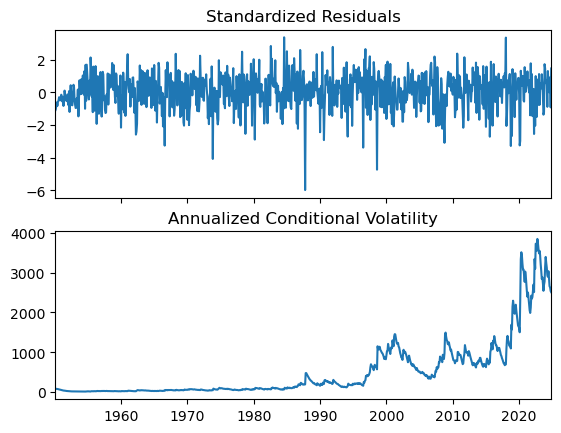

In [33]:
garch_res = arch_model(residus, p=1, o=0, q=1, dist='normal').fit()
print(garch_res.summary())
fig = garch_res.plot(annualize='D')

# Forecast

Now, we are trying to model a HMM-GARCH model to forecast our time series. Indeed, here the goal is to predict stock returns while capturing the volatility. Here, we use stock return to have stationarity in our time series. 

In [36]:
# Fit HMM with 6 regimes
log_returns = log_returns.values.reshape(-1, 1)

hmm_model = GaussianHMM(n_components=6, covariance_type="diag", init_params="c")
hmm_model.fit(log_returns)

hidden_states = hmm_model.decode(log_returns)[1]

When applying a GARCH(1,1) to each of the hidden states, we see that for most of the states the volatility comes from past volatility. This persistance of volatility make our addition of a GARCH component less useful because here the volatility is not due to new shock but past values. For that reason, HMM-GARCH model would be a overkill and not improve the overall performance. 

In [38]:
# Rescale the data
log_returns_rescaled = log_returns * 100

regimes = {}
garch_models = {}

# Loop through each hidden state (regime)
for i in range(hmm_model.n_components):
    regimes[i] = log_returns_rescaled[hidden_states == i]
    
    if len(regimes[i]) > 0:
        print(f"Fitting GARCH(1,1) for Regime {i}...")
        garch_models[i] = arch_model(regimes[i], vol='Garch', p=1, q=1).fit(disp="off")
        print(f"\nRegime {i} GARCH Summary:")
        print(garch_models[i].summary())
    else:
        print(f"\nRegime {i} has no data.")

Fitting GARCH(1,1) for Regime 0...

Regime 0 GARCH Summary:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -213.440
Distribution:                  Normal   AIC:                           434.880
Method:            Maximum Likelihood   BIC:                           444.149
                                        No. Observations:                   75
Date:                Wed, Jan 01 2025   Df Residuals:                       74
Time:                        22:27:30   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu        